In [ ]:
import random, os, sys
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join as opj
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
sys.path.append('..')
from utils import calc_p, bootstrap_cor
from config import TR, RUNS, VID_PER_RUN, STIMDUR, STIM_DICTS, PROJECT_DIR, SUBJECT_LIST, TASK, SCENES
from model_prediction import gen_stiff_pred, gen_mass_pred, cnn_stiff_pred, cnn_mass_pred
from svm_utils import get_gen_distance, get_cnn_distance, find_and_load_jsons, find_max_columns
CUR_DIR = os.getcwd()
%autosave 5
%matplotlib inline

np.random.seed(9)
random.seed(9)

gen_distance = get_gen_distance(verbose=False)
cnn_distance = get_cnn_distance(verbose=False)


def create_violin_plot(human_gen_cor, human_cnn_cor, title):
    data = [human_gen_cor, human_cnn_cor]

    gen_mean = np.mean(human_gen_cor)
    cnn_mean = np.mean(human_cnn_cor)

    fig, ax = plt.subplots()
    sns.violinplot(data=data, ax=ax)

    ax.plot([0], cnn_mean, marker='o', markersize=8, color='black', label='Mean (dnn)')
    ax.plot([1], gen_mean, marker='o', markersize=8, color='black', label='Mean (woven)')

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['woven', 'dnn'])
    ax.set_title(title,fontsize=12)
    ax.set_xlabel('Model')
    ax.set_ylabel('Similarity')
    ax.legend()

    plt.close(fig)  # Hide the figure
    return fig

In [2]:
rois = ['physall', 'v1']
roi_p = 0.05
params = ['l1-0.1', 'l1-1.0', 'l1-10.0', 'l1-100.0']


plot_data, plot_title = [], []
for roi_type in rois:
    validation_res_dir = opj(PROJECT_DIR, 'output', 'svm', 'validation_acc_grid_search', TASK, f'{roi_type}-{roi_p}')
    
    df_validation_all_subs = []
    for sub in SUBJECT_LIST:
        cur_validation_res_dir = opj(validation_res_dir, f'sub-{sub}')

        flag = True
        for param in params:
            cur_f_dir = opj(cur_validation_res_dir, param)
            all_data = find_and_load_jsons(cur_f_dir, n=100)

            if len(all_data) == 0:
                print(f'No json files were found:  {cur_f_dir}')
                continue

            ### load json data
            run_ls, scene_ls, param_ls, value_ls, chain_ls = [], [], [], [], []
            for _scene, _run_dicts in all_data.items():
                for _run, _metrics in _run_dicts.items():
                    for _param, _values in _metrics.items():
                        scene_ls.append(_scene)
                        run_ls.append(_run)
                        param_ls.append(np.mean(_values))
            _param = _param.split('-')[1] + '-' + _param.split('-')[0]

            ###   
            if flag:      
                data = {'scene': scene_ls, 'run': run_ls, _param: param_ls}
                df_validation_cur_sub = pd.DataFrame(data)
                flag = False
            else:
                df_validation_cur_sub[_param] = param_ls


        ##########  Get best validatation param
        _df_values_only = df_validation_cur_sub.drop(columns=['scene', 'run'])
        max_columns = _df_values_only.apply(find_max_columns, axis=1)
        df_validation_cur_sub['best_param'] = max_columns

        df_validation_all_subs.append(df_validation_cur_sub)


    ##############################################################################
    train_res_dir = opj(PROJECT_DIR, 'output', 'svm', 'train', TASK, f'{roi_type}-{roi_p}')

    df_train_all_subs = []
    for sub in SUBJECT_LIST:
        flag = True
        train_res_dir_cur_sub = opj(train_res_dir, f'sub-{sub}')
        for param in params:
            cur_train_res_f = opj(train_res_dir_cur_sub, f'{param}.csv')
            df = pd.read_csv(cur_train_res_f)
            df_means = df.groupby(['run', 'scene']).mean().reset_index()
            if flag:
                df_train_cur_sub = df_means
                df_train_cur_sub[param] = df_train_cur_sub['ACC']
                df_train_cur_sub = df_train_cur_sub.drop(columns=['ACC'])
                flag = False
            else:
                df_train_cur_sub[param] = df_means['ACC']

        df_train_cur_sub = df_train_cur_sub.drop(columns=[col for col in ['iter'] if col in df_train_cur_sub.columns])

        ### This is training results
        df_train_cur_sub = df_train_cur_sub.sort_values(by='scene')
        df_train_cur_sub.reset_index(drop=True, inplace=True)
        df_train_all_subs.append(df_train_cur_sub)



    #############################################################################
    acc_all_subs = []
    for i in range(len(SUBJECT_LIST)):
        df_validation = df_validation_all_subs[i]
        df_train = df_train_all_subs[i]

        df_validation['run'] = df_validation['run'].astype(int)
        df_train['run'] = df_train['run'].astype(int)

        acc_cur_sub = {scene:[] for scene in SCENES}

        for index, row in df_train.iterrows():
            scene = row['scene']
            run = row['run']
            cur_best_params = df_validation.loc[(df_validation['scene'] == scene) & (df_validation['run'] == run), 'best_param'].values[0]


            cur_avg_acc = [row[cur_param] for cur_param in cur_best_params]
            cur_avg_acc = np.mean(cur_avg_acc)
            acc_cur_sub[scene].append(cur_avg_acc)

        acc_cur_sub = {scene: np.mean(acc_cur_sub[scene]) for scene in acc_cur_sub.keys()}
        acc_all_subs.append(list(acc_cur_sub.values()))


    acc_all_subs = np.array(acc_all_subs)
    acc_all_subs_mean = np.mean(acc_all_subs, axis=0)
    split_half_r_all_subs, _ = bootstrap_cor(acc_all_subs)

    ###################################################
    ################ correlation with models
    nsub = acc_all_subs.shape[0]
    human_gen_cor, human_cnn_cor = [], []

    for curboot in range(10000):
        human_boot_indices = np.random.choice(nsub, nsub, replace=True)
        human_boot = acc_all_subs[human_boot_indices, :]
        human_boot_acc_across_scenes = np.mean(human_boot, axis=0)

        model_boot_indices = np.random.choice(62, nsub*20, replace=True)
        gen_boot_pred, cnn_boot_pred = [], []
        for scene in SCENES:
            cur_gen_distance = np.mean(np.array(gen_distance[scene])[model_boot_indices])
            cur_cnn_distance = np.mean(np.array(cnn_distance[scene])[model_boot_indices])
            gen_boot_pred.append(cur_gen_distance)
            cnn_boot_pred.append(cur_cnn_distance)

        cur_human_gen_cor, _ = kendalltau(gen_boot_pred, human_boot_acc_across_scenes)
        cur_human_cnn_cor, _ = kendalltau(cnn_boot_pred, human_boot_acc_across_scenes)

        human_gen_cor.append(cur_human_gen_cor)
        human_cnn_cor.append(cur_human_cnn_cor)

    cnn_cor_mean, cnn_cor_p = round(np.mean(human_cnn_cor),3), round(calc_p(human_cnn_cor),3)
    gen_cor_mean, gen_cor_p = round(np.mean(human_gen_cor),3), round(calc_p(human_gen_cor),3)

    title = f'roi={roi_type}, cor_gen=({gen_cor_mean}, p={gen_cor_p});\n cor_cnn=({cnn_cor_mean}, p={cnn_cor_p})'
    plot_data.append((human_gen_cor, human_cnn_cor))
    plot_title.append(title)
    print(f'roi={roi_type}, cor_gen=({gen_cor_mean}, p={gen_cor_p}); cor_cnn=({cnn_cor_mean}, p={cnn_cor_p}); human_split_half_cor={split_half_r_all_subs}')             


roi=physall, cor_gen=(0.603, p=0.032); cor_cnn=(0.047, p=0.526); human_split_half_cor=0.5228
roi=v1, cor_gen=(0.274, p=0.205); cor_cnn=(0.56, p=0.031); human_split_half_cor=0.509


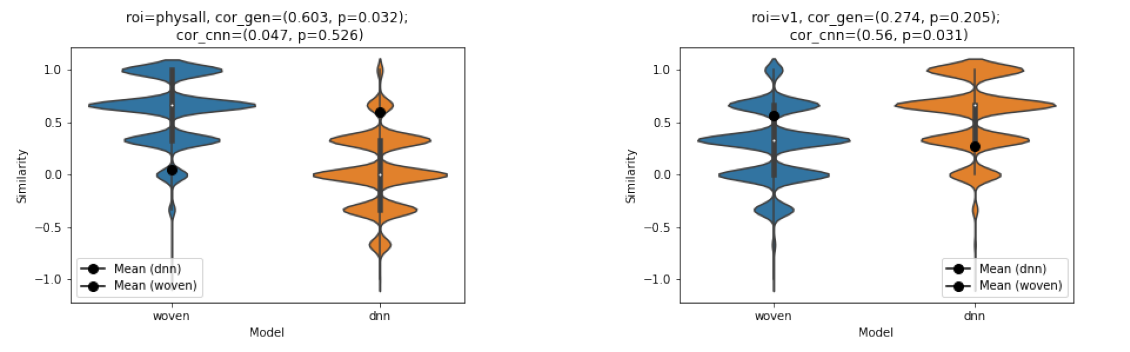

In [3]:
figures = []
for i, (gen_i, cnn_i) in enumerate(plot_data):
    fig = create_violin_plot(gen_i, cnn_i, plot_title[i])
    figures.append(fig)

fig, axes = plt.subplots(1, len(figures), figsize=(20, 15))

for ax, fig in zip(axes, figures):
    fig.canvas.draw()
    ax.imshow(fig.canvas.buffer_rgba())
    ax.axis('off')
plt.show()
